In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import requests
from pandas.compat import StringIO
#Getting stock data
def get_eod_data(symbol, api_token='5cb671b0b4a790.35526238', session=None):
    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        params = {'api_token': api_token}
        r = session.get(url, params=params)
        if r.status_code == requests.codes.ok:
            df = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0],)
            return df
        else:
            raise Exception(r.status_code, r.reason, url)

In [3]:
df = get_eod_data('MSFT.US') #Using Microsoft Stock
df=df[df['Date'].dt.year==2019]
#df=df[df['Date'].dt.month == 5]
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist() #时间
df.head()

C:\Users\zliu2\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


,Date,Open,High,Low,Close,Adjusted_close,Volume
8270,2019-01-02,99.55,101.7500,98.9400,101.12,100.3187,35329345
8271,2019-01-03,100.10,100.1850,97.2000,97.40,96.6281,42578410
8272,2019-01-04,99.72,102.5100,98.9300,101.93,101.1222,44060620
8273,2019-01-07,101.64,103.2681,100.9800,102.06,101.2512,35656136
8274,2019-01-08,103.04,103.9700,101.7134,102.80,101.9853,31514415


In [4]:
close = df.Close.values.tolist() #选取收盘数据做测试
initial_money = 3000 
window_size = 30 
skip = 1

In [5]:
#define classes for neural net
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_    #output

def relu(X):
    return np.maximum(X, 0)    #Rectified Linear Unit - activation function
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))   #Exponential
    return e_x / np.sum(e_x, axis=-1, keepdims=True)      #Exponential divided by the exponential of whole y axis

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [6]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,  
                state_size, window_size, trend, skip, initial_money):    
        self.population_size = population_size 
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size #状态空间
        self.window_size = window_size #滑动窗口大小
        self.half_window = window_size // 2
        self.trend = trend #data
        self.skip = skip #采取动作的步长，1代表每个时刻都操作
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    #变异（定义如何随机挑选0-1互换的位置）
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    #父母的DNA交叉配对(定义到底怎么个交叉法)
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t): #某t时刻的状态
        window_size = self.window_size + 1
        d = t - window_size + 1 
        #早期天数不够窗口打小，用0时刻来凑，即填补相应个数
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])#每步收益
        return np.array([res]) #作为状态编码
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money #启动资金
        starting_money = initial_money
        state = self.get_state(0)#初始状态
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)#根据状态选动作
            next_state = self.get_state(t + 1)#得到下一个状态
            #action=1为买入，资金够用，且剩下的长度足够
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])#买入
                initial_money -= self.trend[t]#交易
                states_buy.append(t)#记录
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            #action=2为卖出
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)#卖出
                initial_money += self.trend[t] #交易
                states_sell.append(t)#记录
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            #下一状态
            state = next_state
        #计算收益
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = [] #仓位
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness() #计算适应度得分，适应度越高的越好
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            #对于种群中所有个体，在种群中挑选另一个体进行配对
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [7]:
#change the population_size from 100 to 200
population_size = 250 #种群的个体数目
generations = 100 #有多少代（主循环的迭代次数）
mutation_rate = 0.1 #变异的概率/强度
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [8]:
fittest_nets = neural_evolve.evolve(60) #change from 75 to 60

epoch 5, fittest individual 0 with accuracy 5.167000
epoch 10, fittest individual 0 with accuracy 5.631000
epoch 15, fittest individual 0 with accuracy 5.631000
epoch 20, fittest individual 0 with accuracy 8.622000
epoch 25, fittest individual 0 with accuracy 8.622000
epoch 30, fittest individual 0 with accuracy 8.622000
epoch 35, fittest individual 0 with accuracy 8.622000
epoch 40, fittest individual 0 with accuracy 8.622000
epoch 45, fittest individual 0 with accuracy 8.622000
epoch 50, fittest individual 0 with accuracy 8.622000
epoch 55, fittest individual 0 with accuracy 8.622000
epoch 60, fittest individual 0 with accuracy 8.622000


In [9]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)

day 1: buy 1 unit at price 97.400000, total balance 2902.600000
day 2, sell 1 unit at price 101.930000, investment 4.650924 %, total balance 3004.530000,
day 5: buy 1 unit at price 104.270000, total balance 2900.260000
day 6: buy 1 unit at price 103.600000, total balance 2796.660000
day 7, sell 1 unit at price 102.800000, investment -1.409801 %, total balance 2899.460000,
day 8: buy 1 unit at price 102.050000, total balance 2797.410000
day 9, sell 1 unit at price 105.010000, investment 1.361004 %, total balance 2902.420000,
day 10: buy 1 unit at price 105.380000, total balance 2797.040000
day 11, sell 1 unit at price 106.120000, investment 3.988241 %, total balance 2903.160000,
day 12: buy 1 unit at price 107.710000, total balance 2795.450000
day 13: buy 1 unit at price 105.680000, total balance 2689.770000
day 14, sell 1 unit at price 106.710000, investment 1.262099 %, total balance 2796.480000,
day 15: buy 1 unit at price 106.200000, total balance 2690.280000
day 16, sell 1 unit at p

day 111, sell 1 unit at price 131.490000, investment 2.670415 %, total balance 2442.570000,
day 112, sell 1 unit at price 132.320000, investment 4.832832 %, total balance 2574.890000,
day 114, sell 1 unit at price 132.850000, investment 4.688731 %, total balance 2707.740000,
day 115, sell 1 unit at price 135.160000, investment 7.065906 %, total balance 2842.900000,
day 116, sell 1 unit at price 135.690000, investment 6.157096 %, total balance 2978.590000,
day 117: buy 1 unit at price 136.950000, total balance 2841.640000
day 118, sell 1 unit at price 136.970000, investment 3.295626 %, total balance 2978.610000,
day 119, sell 1 unit at price 137.780000, investment 4.299773 %, total balance 3116.390000,
day 120: buy 1 unit at price 133.430000, total balance 2982.960000
day 121: buy 1 unit at price 133.930000, total balance 2849.030000
day 122, sell 1 unit at price 134.150000, investment -2.044542 %, total balance 2983.180000,
day 123, sell 1 unit at price 133.960000, investment 0.397212 

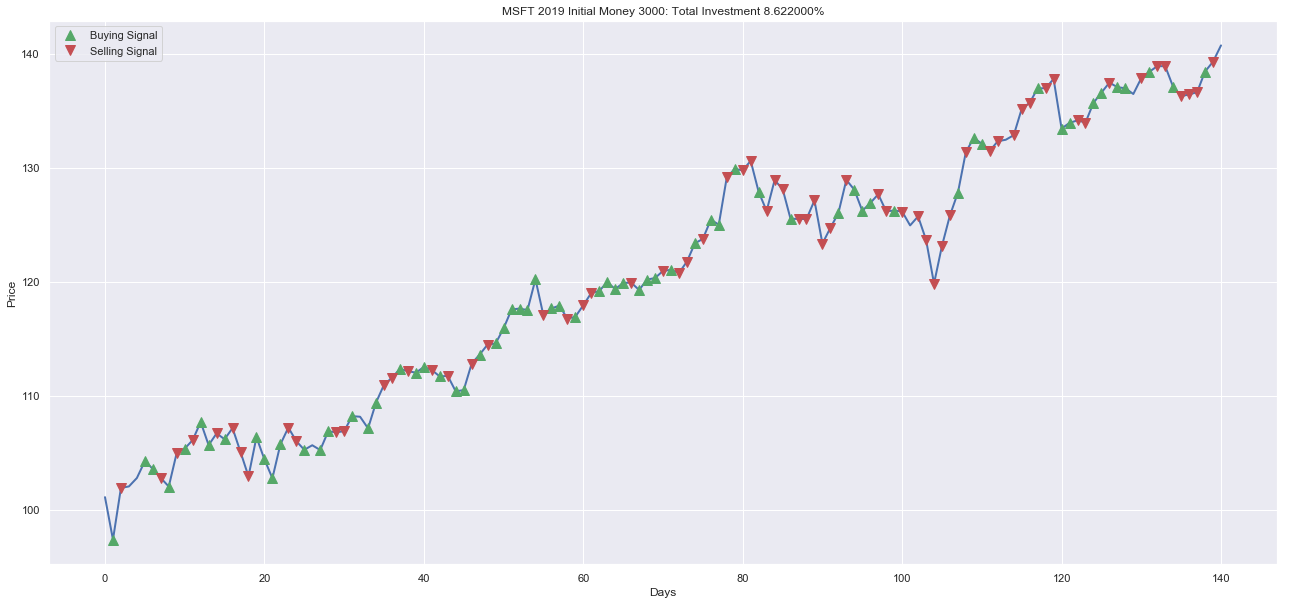

In [10]:
%matplotlib inline
fig = plt.figure(figsize = (22,10))
plt.plot(close, color='b', lw=2.)
plt.plot(close, '^', markersize=10, color='g', label = 'Buying Signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'Selling Signal', markevery = states_sell)
plt.title('MSFT 2019 Initial Money 3000: Total Investment %f%%'%(invest))
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()